<a href="https://colab.research.google.com/github/Faza20-lab/Projet_stats/blob/Faza/Projet_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.stats import kstest
import scipy.stats as st
from scipy.stats import genextreme
from scipy.stats import genpareto

In [49]:
from google.colab import drive
drive.mount('/content/drive')

file_prec = '/content/drive/MyDrive/data/ERA5_prec_daily_1940_2023_FR_brittany.nc'
ds = xr.open_dataset(file_prec)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
!pip install netCDF4

In [51]:
# Vérifie les dimensions du dataset et quelques dates pour contrôle
ds.sizes
print(ds['time'])
ds.time.values[:10]     # 10 premières dates
ds.time.values[10:]     # dates suivantes

<xarray.DataArray 'time' (time: 30449)> Size: 244kB
array(['1940-01-01T00:00:00.000000000', '1940-01-02T00:00:00.000000000',
       '1940-01-03T00:00:00.000000000', ..., '2023-05-11T00:00:00.000000000',
       '2023-05-12T00:00:00.000000000', '2023-05-13T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 244kB 1940-01-01 1940-01-02 ... 2023-05-13
    height   float64 8B ...


array(['1940-01-11T00:00:00.000000000', '1940-01-12T00:00:00.000000000',
       '1940-01-13T00:00:00.000000000', ...,
       '2023-05-11T00:00:00.000000000', '2023-05-12T00:00:00.000000000',
       '2023-05-13T00:00:00.000000000'], dtype='datetime64[ns]')

In [52]:
# Affiche les valeurs des latitudes et longitudes de la grille
print(ds.Latitude.values)
print(ds.Longitude.values)

[49.   48.75 48.5  48.25 48.   47.75 47.5  47.25 47.   46.75 46.5  46.25]
[-4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25 -2.
 -1.75 -1.5 ]


# **Precipitation section**

In [53]:
# Extraction de la carte de précipitation pour le premier jour
da = ds['pr'].isel(time=0)
df = da.to_dataframe().reset_index()

print(da.shape)        # dimensions lat × lon
print(da.values.size)  # nombre total de points
print(df.head())       # aperçu du tableau

(12, 14)
168
   Latitude  Longitude       time   lon   lat  height  pr
0      49.0      -4.75 1940-01-01 -4.75  49.0     0.0 NaN
1      49.0      -4.50 1940-01-01 -4.50  49.0     0.0 NaN
2      49.0      -4.25 1940-01-01 -4.25  49.0     0.0 NaN
3      49.0      -4.00 1940-01-01 -4.00  49.0     0.0 NaN
4      49.0      -3.75 1940-01-01 -3.75  49.0     0.0 NaN


In [54]:
# Affiche les dimensions du champ de précipitation (temps × lat × lon)
print(ds['pr'].shape)

(12, 14, 30449)


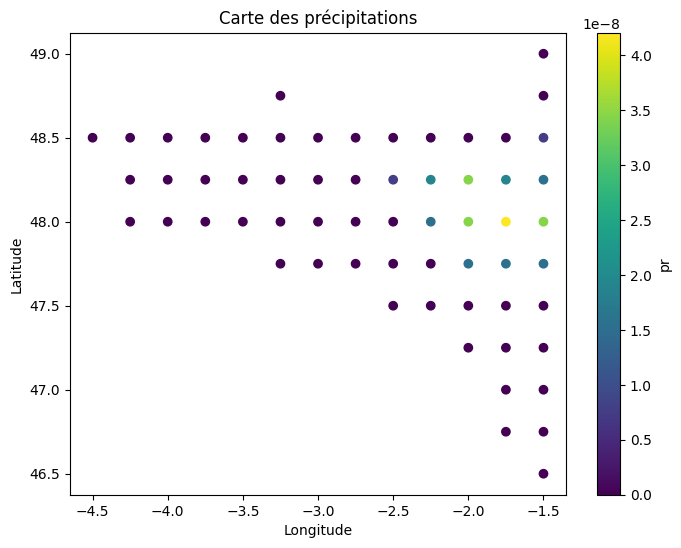

In [55]:
# Carte des précipitations pour 01-01-1940
plt.figure(figsize=(8,6))
plt.scatter(df["Longitude"], df["Latitude"], c=df["pr"])
plt.colorbar(label="pr")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Carte des précipitations")
plt.show()

In [56]:
ds_djf = ds.sel(time = ds['time'].dt.month.isin([1, 2, 12])) # Sélectionne les jours de Décembre, Janvier et Février

# Affiche le dataset filtré DJF
print(ds_djf)

# Affiche les dimensions (lat, lon, nombre de jours DJF)
ds_djf.sizes

<xarray.Dataset> Size: 5MB
Dimensions:    (Latitude: 12, Longitude: 14, time: 7550)
Coordinates:
  * Latitude   (Latitude) float64 96B 49.0 48.75 48.5 48.25 ... 46.75 46.5 46.25
  * Longitude  (Longitude) float64 112B -4.75 -4.5 -4.25 ... -2.0 -1.75 -1.5
  * time       (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    lon        (Longitude) float64 112B ...
    lat        (Latitude) float64 96B ...
    height     float64 8B ...
Data variables:
    pr         (Latitude, Longitude, time) float32 5MB ...


Frozen({'Latitude': 12, 'Longitude': 14, 'time': 7550})

In [57]:
# Calcule la somme de précipitations sur toute la zone pour chaque jour DJF
somme_quotidienne_pr_djf = ds_djf['pr'].sum(dim=['Latitude', 'Longitude'])
print(somme_quotidienne_pr_djf)

# X : précipitations quotidiennes intégrées en hiver
X = somme_quotidienne_pr_djf
print(len(X))

<xarray.DataArray 'pr' (time: 7550)> Size: 30kB
array([2.7539755e-07, 0.0000000e+00, 3.9131618e-03, ..., 1.3772695e-05,
       2.4685729e-05, 2.1683841e-03], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    height   float64 8B ...
7550


In [58]:
#Conversion de kg/m²/s en mm-1
seconds_per_day = 24 * 60 * 60  # 86400

X_mm_per_day = X * seconds_per_day # x(1000/1000)

# Mettre à jour le DataArray avec une nouvelle unité
X_mm_per_day = X_mm_per_day.rename("pr_mm_per_day")
X_mm_per_day.attrs['units'] = 'mm/day'
X_mm_per_day.attrs['description'] = 'Précipitation journalière convertie de kg/m²/s → mm/j'


print(X_mm_per_day)

<xarray.DataArray 'pr_mm_per_day' (time: 7550)> Size: 30kB
array([2.3794349e-02, 0.0000000e+00, 3.3809717e+02, ..., 1.1899608e+00,
       2.1328471e+00, 1.8734839e+02], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    height   float64 8B ...
Attributes:
    units:        mm/day
    description:  Précipitation journalière convertie de kg/m²/s → mm/j


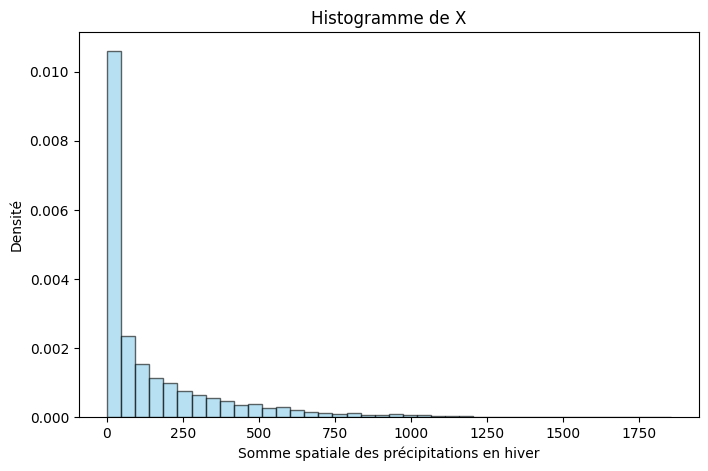

In [59]:
#Histogramme de X
plt.figure(figsize=(8,5))

plt.hist(X_mm_per_day, bins=40, density=True, alpha=0.6, color='skyblue', edgecolor='black')

plt.xlabel("Somme spatiale des précipitations en hiver")
plt.ylabel("Densité")
plt.title("Histogramme de X")

plt.show()

### **Wind section**

In [60]:
file_wind = '/content/drive/MyDrive/data/ERA5_wind_daily_1940_2023_FR_brittany.nc'
ds2 = xr.open_dataset(file_wind)

In [61]:
## Aperçu des premières lignes du dataset
ds2.head()

<xarray.Dataset> Size: 708B
Dimensions:    (Latitude: 5, Longitude: 5, time: 5)
Coordinates:
  * Latitude   (Latitude) float64 40B 49.0 48.75 48.5 48.25 48.0
  * Longitude  (Longitude) float64 40B -4.75 -4.5 -4.25 -4.0 -3.75
  * time       (time) datetime64[ns] 40B 1940-01-01 1940-01-02 ... 1940-01-05
    lon        (Longitude) float64 40B ...
    lat        (Latitude) float64 40B ...
    height     float64 8B ...
Data variables:
    sfcWind    (Latitude, Longitude, time) float32 500B ...

In [62]:
# Sélection des jours d'hiver (Déc–Janv–Fév)
ds2_djf = ds2.sel(time = ds2['time'].dt.month.isin([1, 2, 12]))

print(ds2_djf)     # affiche le dataset filtré
ds2_djf.sizes      # dimensions du sous-ensemble DJF

<xarray.Dataset> Size: 5MB
Dimensions:    (Latitude: 12, Longitude: 14, time: 7550)
Coordinates:
  * Latitude   (Latitude) float64 96B 49.0 48.75 48.5 48.25 ... 46.75 46.5 46.25
  * Longitude  (Longitude) float64 112B -4.75 -4.5 -4.25 ... -2.0 -1.75 -1.5
  * time       (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    lon        (Longitude) float64 112B ...
    lat        (Latitude) float64 96B ...
    height     float64 8B ...
Data variables:
    sfcWind    (Latitude, Longitude, time) float32 5MB ...


Frozen({'Latitude': 12, 'Longitude': 14, 'time': 7550})

In [63]:
# Moyenne du vent sur toute la zone pour chaque jour DJF
mean_quotidienne_sfcWind_djf = ds2_djf['sfcWind'].mean(dim=['Latitude', 'Longitude'])
print(mean_quotidienne_sfcWind_djf)

# Y = vent moyen quotidien en hiver
Y = mean_quotidienne_sfcWind_djf
print(len(Y))


<xarray.DataArray 'sfcWind' (time: 7550)> Size: 30kB
array([7.834759 , 7.027803 , 6.503153 , ..., 8.036703 , 7.9032125,
       7.3788795], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    height   float64 8B ...
7550


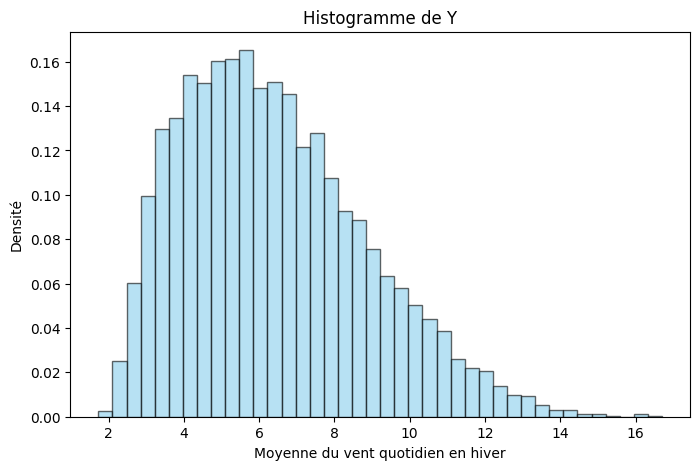

In [64]:
#Histogramme de Y
plt.figure(figsize=(8,5))

plt.hist(Y, bins=40, density=True, alpha=0.6, color='skyblue', edgecolor='black')

plt.xlabel("Moyenne du vent quotidien en hiver")
plt.ylabel("Densité")
plt.title("Histogramme de Y")

plt.show()


# **1) X distribution**

## **Gamma**

In [65]:
#Gamma fit
params_gamma = gamma.fit(X)
print("Paramètres Gamma :", params_gamma)

Paramètres Gamma : (np.float64(0.39742732828921445), np.float64(-1.4202669262886049e-08), np.float64(0.004161354231805459))


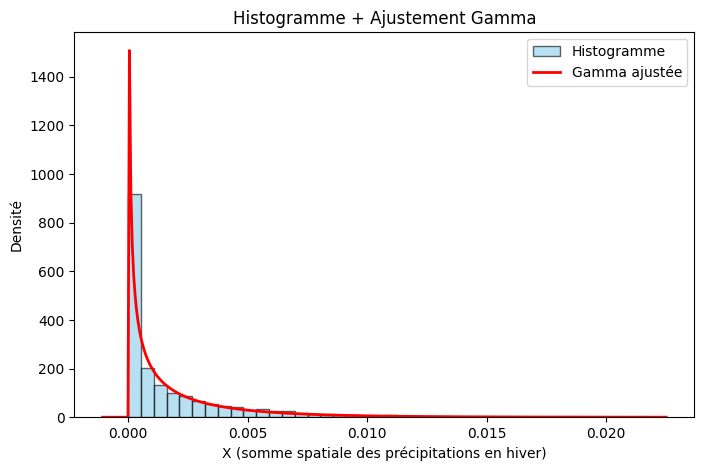

In [66]:
#Histogramme + densité Gamma ajustée

# Ajustement gamma
params = gamma.fit(X)

plt.figure(figsize=(8,5))

# Histogramme
plt.hist(X, bins=40, density=True, alpha=0.6, color='skyblue', edgecolor='black', label="Histogramme")

# Courbe théorique
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, gamma.pdf(xx, *params), 'r-', lw=2, label="Gamma ajustée")

plt.xlabel("X (somme spatiale des précipitations en hiver)")
plt.ylabel("Densité")
plt.title("Histogramme + Ajustement Gamma")
plt.legend()

plt.show()

In [67]:
# Test KS (Kolmogorov-Smirnov) pour la qualité d’ajustement
ks_gamma = kstest(X, 'gamma', params_gamma)
print("Test KS pour Gamma :", ks_gamma)
print("p-value :", ks_gamma.pvalue)

Test KS pour Gamma : KstestResult(statistic=np.float64(0.03275051301580745), pvalue=np.float64(1.803655000186417e-07), statistic_location=np.float32(0.0021361932), statistic_sign=np.int8(-1))
p-value : 1.803655000186417e-07


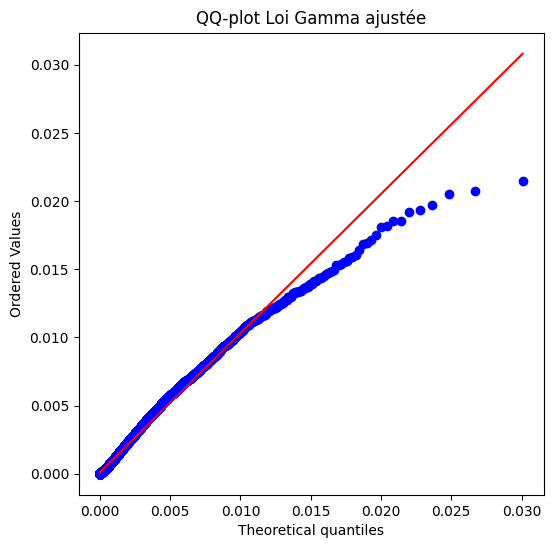

In [68]:
# Diagramme Quantile-Quantile de la Gamma
plt.figure(figsize=(6,6))
st.probplot(X, dist=gamma(*params_gamma), plot=plt)
plt.title("QQ-plot Loi Gamma ajustée")
plt.show()

## **Generalized extreme value**

In [69]:
#Extraire le maximum DJF de chaque année: maximum par bloc (=hiver)

# Regrouper chaque date par année => ajouter la coordonnée "year"
years = ds_djf['time'].dt.year

# Maximum de X pour chaque année DJF
X_max = X.groupby(years).max().values
print("Taille :", len(X_max))
print(X_max[:10])

Taille : 84
[0.00984053 0.02076684 0.00939425 0.02144337 0.01411245 0.00786892
 0.01057356 0.01392205 0.01273243 0.01091694]


In [70]:
# Fit GEV
params_gev = genextreme.fit(X_max)
print("Paramètres GEV :", params_gev)


Paramètres GEV : (np.float64(0.10708342796807288), np.float64(0.011648153806172713), np.float64(0.0028572886118932617))


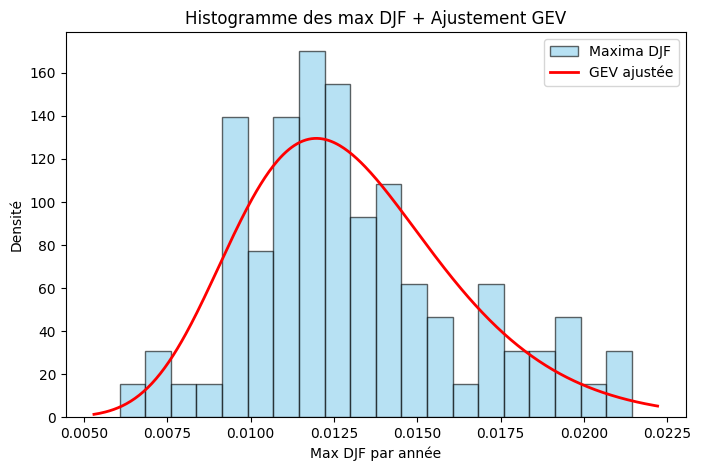

In [71]:
plt.figure(figsize=(8,5))
# Histogramme des maxima
plt.hist(X_max, bins=20, density=True, alpha=0.6,
         color="skyblue", edgecolor="black", label="Maxima DJF")

# Domaine
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)

# Densité GEV ajustée
plt.plot(xx, genextreme.pdf(xx, *params_gev),
         'r-', lw=2, label="GEV ajustée")

plt.xlabel("Max DJF par année")
plt.ylabel("Densité")
plt.title("Histogramme des max DJF + Ajustement GEV")
plt.legend()
plt.show()

In [72]:
# Test KS pour GEV
ks_gev = kstest(X_max, 'genextreme', params_gev)
print("KS GEV :", ks_gev)
print("p-value :", ks_gev.pvalue)


KS GEV : KstestResult(statistic=np.float64(0.05535369064112017), pvalue=np.float64(0.9464435960336187), statistic_location=np.float64(0.012995472177863121), statistic_sign=np.int8(1))
p-value : 0.9464435960336187


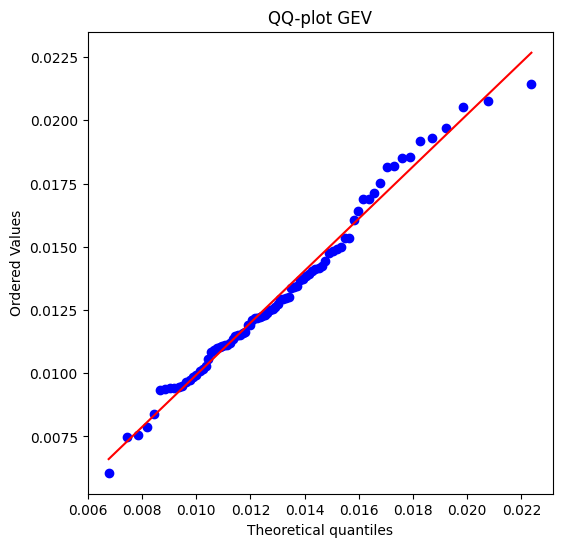

In [73]:
# QQ-plot for GEV
plt.figure(figsize=(6,6))
st.probplot(X_max, dist=genextreme(*params_gev), plot=plt)
plt.title("QQ-plot GEV")
plt.show()

In [74]:
#Calcul des seuils extrêmes: quantiles 95%, 99%
q95 = genextreme.ppf(0.95, *params_gev)
q99 = genextreme.ppf(0.99, *params_gev)

print("Seuil 95% :", q95)
print("Seuil 99% :", q99)

Seuil 95% : 0.018917620935752198
Seuil 99% : 0.02202681868364487


## **Generalized Pareto distribution**

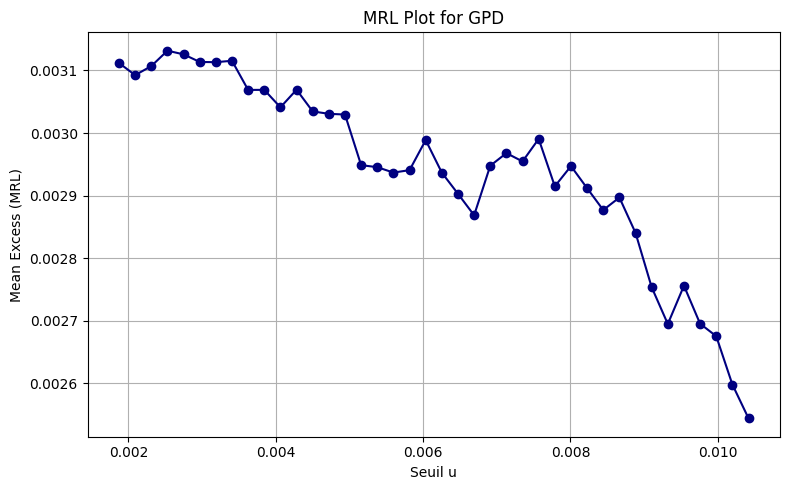

In [80]:
# Pour chaque seuil u, on calcule la moyenne des excès
# MRL(u) = moyenne de (X - u) quand X > u
def mrl(data, seuils):        # Mean residual life
    mrl_values = []

    for u in seuils:
        # Excès au-dessus du seuil u
        exces = data[data > u] - u

        # Si aucun excès au-dessus du seuil → MRL non défini
        if len(exces) == 0:
            mrl_values.append(np.nan)
        else:
            mrl_values.append(exces.mean())

    return mrl_values

# Gamme des seuils entre les quantiles 70% et 98%
u_values = np.linspace(
    np.percentile(X, 70),
    np.percentile(X, 98),
    40
)
# Calcul du MRL pour chaque seuil
mrl_values = mrl(X, u_values)

# Tracé
plt.figure(figsize=(8,5))
plt.plot(u_values, mrl_values, 'o-', color='navy')

plt.xlabel("Seuil u")
plt.ylabel("Mean Excess (MRL)")
plt.title("MRL Plot for GPD")
plt.grid(True)
plt.tight_layout()
plt.show()


In [81]:
# Fit GPD
u = np.percentile(X, 95)  # exemple
excess = X[X > u] - u

params_gpd = genpareto.fit(excess)
print("Paramètres GPD :", params_gpd)

Paramètres GPD : (np.float64(0.4785170339916997), np.float64(1.8188599773461045e-06), np.float64(0.0022633537716976867))


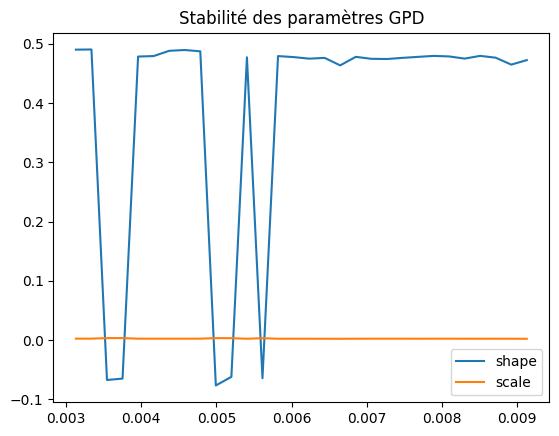

In [77]:
# Stabilité des paramètres GPD en fct du seuil u

shape_vals = []   # stocke les valeurs du paramètre de forme ξ
scale_vals = []   # stocke les valeurs du paramètre d'échelle σ

# Liste de seuils u à tester : entre les quantiles 80% et 97%
seuils = np.linspace(np.percentile(X,80), np.percentile(X,97), 30)

for u in seuils:
    # Excès : valeurs supérieures au seuil
    exc = X[X > u] - u

    # On ne fit la GPD que si on a assez d'excès
    if len(exc) > 20:
        shape, loc, scale = genpareto.fit(exc)
        shape_vals.append(shape)
        scale_vals.append(scale)
    else:
        # Trop peu d'excès → on met NaN
        shape_vals.append(np.nan)
        scale_vals.append(np.nan)

# Tracé des paramètres GPD en fonction du seuil
plt.plot(seuils, shape_vals, label="Paramètre shape ξ")
plt.plot(seuils, scale_vals, label="Paramètre scale σ")
plt.legend()
plt.title("Stabilité des paramètres GPD selon le seuil")
plt.show()


Zone stable pour ξ à partir de ~0.006, donc le seuil optimal est : u = 0.006

In [97]:
# Choix du seuil optimal
u = 0.006

# Excès au-dessus du seuil
exces = X[X > u] - u

# Ajustement GPD
params_gpd = genpareto.fit(exces)
print("Paramètres GPD :", params_gpd)

Paramètres GPD : (np.float64(0.47729107529077935), np.float64(3.926866311178507e-06), np.float64(0.0022266873030981453))


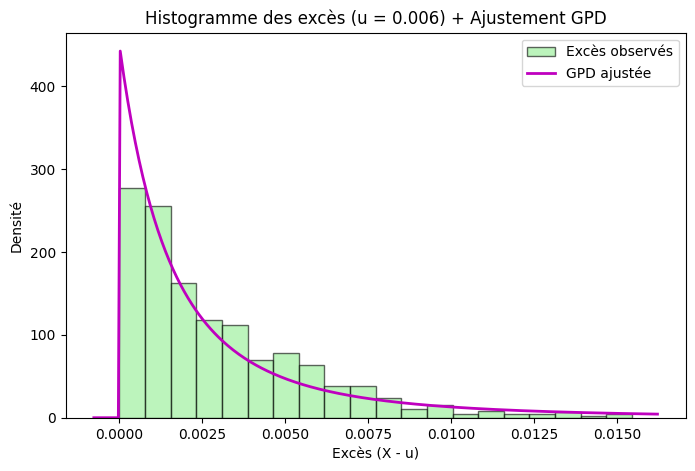

In [90]:
# Histogramme des excès avec la densité GPD ajustée
plt.figure(figsize=(8,5))

# Histogramme normalisé
plt.hist(exces, bins=20, density=True, alpha=0.6,
         color="lightgreen", edgecolor="black", label="Excès observés")

# Domaine pour la courbe
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 300)

# Courbe GPD ajustée
plt.plot(xx, genpareto.pdf(xx, *params_gpd), 'm-', lw=2,
         label="GPD ajustée")

plt.xlabel("Excès (X - u)")
plt.ylabel("Densité")
plt.title(f"Histogramme des excès (u = {u}) + Ajustement GPD")
plt.legend()
plt.show()

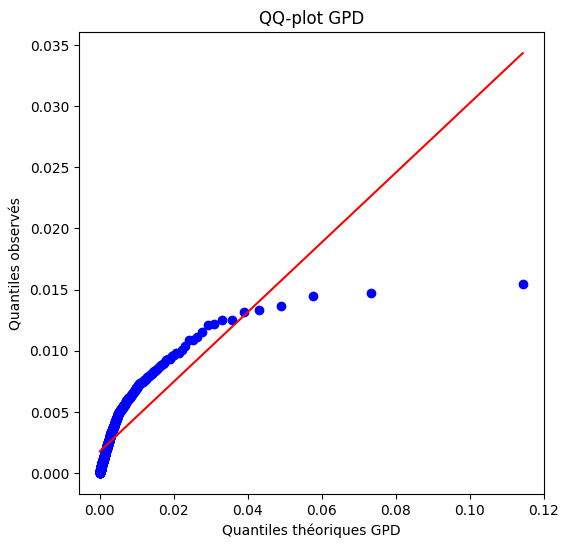

In [91]:
# QQ-plot pour vérifier si les excès suivent bien une GPD
plt.figure(figsize=(6,6))
st.probplot(exces, dist=genpareto(*params_gpd), plot=plt)

plt.title("QQ-plot GPD")
plt.xlabel("Quantiles théoriques GPD")
plt.ylabel("Quantiles observés")
plt.show()

In [98]:
# Test KS pour la GPD ajustée
ks_gpd = kstest(exces, 'genpareto', params_gpd)
print("KS-test GPD :", ks_gpd)
print("p-value :", ks_gpd.pvalue)

KS-test GPD : KstestResult(statistic=np.float64(0.07330959473377224), pvalue=np.float64(0.0026053622625480622), statistic_location=np.float32(0.0007509948), statistic_sign=np.int8(-1))
p-value : 0.0026053622625480622


## **2) Y distribution**

## **Gamma**

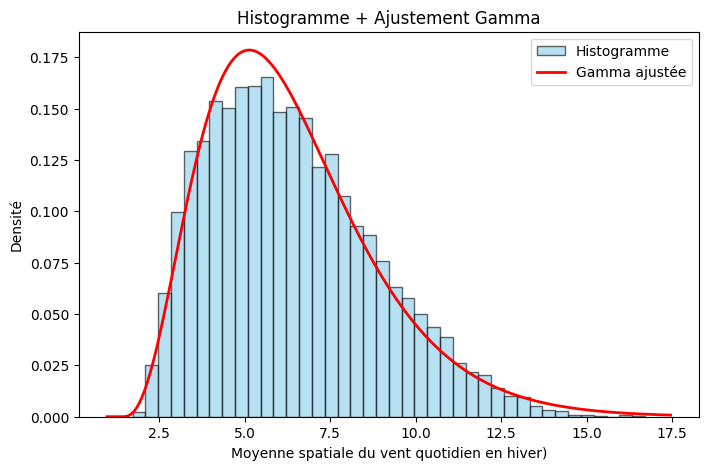

In [99]:
#Histogramme + densité Gamma ajustée

# Ajustement gamma
params = gamma.fit(Y)

plt.figure(figsize=(8,5))

# Histogramme
plt.hist(Y, bins=40, density=True, alpha=0.6, color='skyblue', edgecolor='black', label="Histogramme")

# Courbe théorique
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, gamma.pdf(xx, *params), 'r-', lw=2, label="Gamma ajustée")

plt.xlabel("Moyenne spatiale du vent quotidien en hiver)")
plt.ylabel("Densité")
plt.title("Histogramme + Ajustement Gamma")
plt.legend()

plt.show()

In [100]:
# Test KS (Kolmogorov-Smirnov) pour la qualité d’ajustement
ks_gamma = kstest(Y, 'gamma', params_gamma)
print("Test KS pour Gamma :", ks_gamma)
print("p-value :", ks_gamma.pvalue)

Test KS pour Gamma : KstestResult(statistic=np.float64(1.0), pvalue=np.float64(0.0), statistic_location=np.float32(1.7290397), statistic_sign=np.int8(-1))
p-value : 0.0


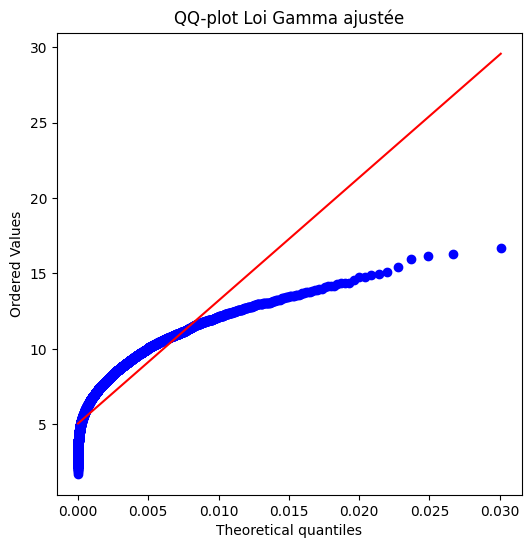

In [101]:
# Diagramme Quantile-Quantile de la Gamma
plt.figure(figsize=(6,6))
st.probplot(Y, dist=gamma(*params_gamma), plot=plt)
plt.title("QQ-plot Loi Gamma ajustée")
plt.show()

## **GEV**

In [103]:
#Extraire le maximum DJF de chaque année: maximum par bloc (=hiver)

# Regrouper chaque date par année => ajouter la coordonnée "year"
years = ds_djf['time'].dt.year

# Maximum de Y pour chaque année DJF
Y_max = Y.groupby(years).max().values
print("Taille :", len(Y_max))
print(Y_max[:10])

Taille : 84
[11.20478725 13.50259304 12.40323639 14.13482094 11.91625214 11.89690399
 12.69151115 11.08776093 11.05125523 13.68508244]


In [104]:
# Fit GEV
params_gev = genextreme.fit(Y_max)
print("Paramètres GEV :", params_gev)

Paramètres GEV : (np.float64(0.19964366985853074), np.float64(12.342363023742056), np.float64(1.270954579987078))


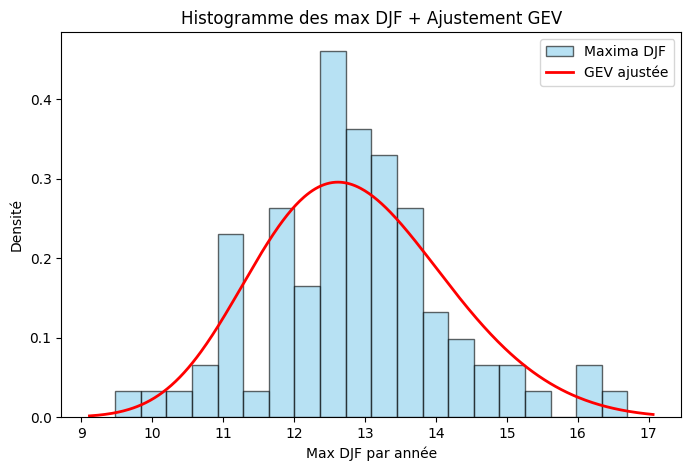

In [105]:
plt.figure(figsize=(8,5))
# Histogramme des maxima
plt.hist(Y_max, bins=20, density=True, alpha=0.6,
         color="skyblue", edgecolor="black", label="Maxima DJF")

# Domaine
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)

# Densité GEV ajustée
plt.plot(xx, genextreme.pdf(xx, *params_gev),
         'r-', lw=2, label="GEV ajustée")

plt.xlabel("Max DJF par année")
plt.ylabel("Densité")
plt.title("Histogramme des max DJF + Ajustement GEV")
plt.legend()
plt.show()

In [106]:
# Test KS pour GEV
ks_gev = kstest(Y_max, 'genextreme', params_gev)
print("KS GEV :", ks_gev)
print("p-value :", ks_gev.pvalue)

KS GEV : KstestResult(statistic=np.float64(0.07035157383908763), pvalue=np.float64(0.7733620780424612), statistic_location=np.float64(12.383679389953613), statistic_sign=np.int8(-1))
p-value : 0.7733620780424612


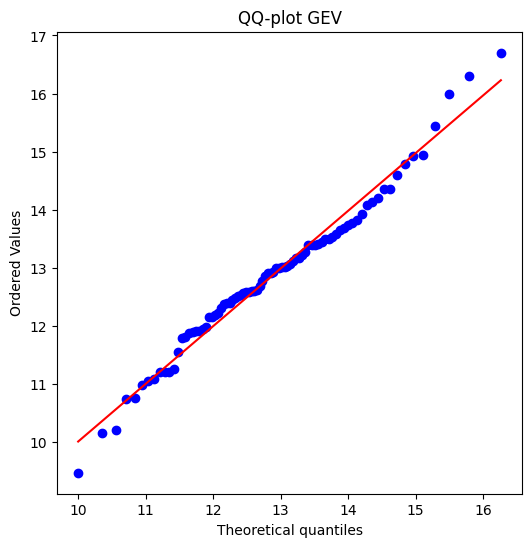

In [107]:
# QQ-plot for GEV
plt.figure(figsize=(6,6))
st.probplot(Y_max, dist=genextreme(*params_gev), plot=plt)
plt.title("QQ-plot GEV")
plt.show()

In [108]:
#Calcul des seuils extrêmes: quantiles 95%, 99%
q95 = genextreme.ppf(0.95, *params_gev)
q99 = genextreme.ppf(0.99, *params_gev)

print("Seuil 95% :", q95)
print("Seuil 99% :", q99)

Seuil 95% : 15.190069716761466
Seuil 99% : 16.167373857214965


## **GPD**

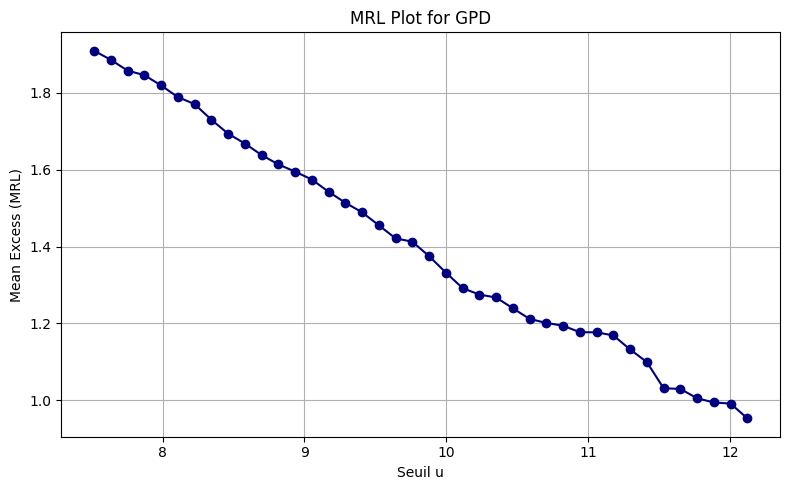

In [109]:
# Pour chaque seuil u, on calcule la moyenne des excès
# MRL(u) = moyenne de (Y - u) quand Y > u
def mrl(data, seuils):        # Mean residual life
    mrl_values = []

    for u in seuils:
        # Excès au-dessus du seuil u
        exces = data[data > u] - u

        # Si aucun excès au-dessus du seuil → MRL non défini
        if len(exces) == 0:
            mrl_values.append(np.nan)
        else:
            mrl_values.append(exces.mean())

    return mrl_values

# Gamme des seuils entre les quantiles 70% et 98%
u_values = np.linspace(
    np.percentile(Y, 70),
    np.percentile(Y, 98),
    40
)
# Calcul du MRL pour chaque seuil
mrl_values = mrl(Y, u_values)

# Tracé
plt.figure(figsize=(8,5))
plt.plot(u_values, mrl_values, 'o-', color='navy')

plt.xlabel("Seuil u")
plt.ylabel("Mean Excess (MRL)")
plt.title("MRL Plot for GPD")
plt.grid(True)
plt.tight_layout()
plt.show()


In [110]:
# Fit GPD
u = np.percentile(Y, 95)  # exemple
excess = Y[Y > u] - u

params_gpd = genpareto.fit(excess)
print("Paramètres GPD :", params_gpd)

Paramètres GPD : (np.float64(-0.1575791625963992), np.float64(5.715074937180732e-06), np.float64(1.363017956897948))


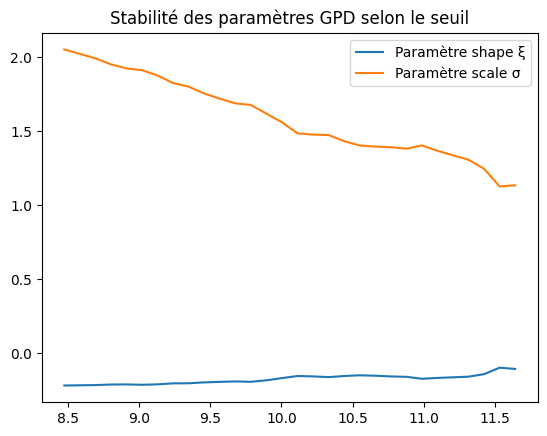

In [111]:
# Stabilité des paramètres GPD en fct du seuil u

shape_vals = []   # stocke les valeurs du paramètre de forme ξ
scale_vals = []   # stocke les valeurs du paramètre d'échelle σ

# Liste de seuils u à tester : entre les quantiles 80% et 97%
seuils = np.linspace(np.percentile(Y,80), np.percentile(Y,97), 30)

for u in seuils:
    # Excès : valeurs supérieures au seuil
    exc = Y[Y > u] - u

    # On ne fit la GPD que si on a assez d'excès
    if len(exc) > 20:
        shape, loc, scale = genpareto.fit(exc)
        shape_vals.append(shape)
        scale_vals.append(scale)
    else:
        # Trop peu d'excès → on met NaN
        shape_vals.append(np.nan)
        scale_vals.append(np.nan)

# Tracé des paramètres GPD en fonction du seuil
plt.plot(seuils, shape_vals, label="Paramètre shape ξ")
plt.plot(seuils, scale_vals, label="Paramètre scale σ")
plt.legend()
plt.title("Stabilité des paramètres GPD selon le seuil")
plt.show()


In [112]:
# Choix du seuil optimal
u = 10

# Excès au-dessus du seuil
exces = Y[Y > u] - u

# Ajustement GPD
params_gpd = genpareto.fit(exces)
print("Paramètres GPD :", params_gpd)

Paramètres GPD : (np.float64(-0.1680439202897986), np.float64(0.00022219997612816963), np.float64(1.560583778382723))


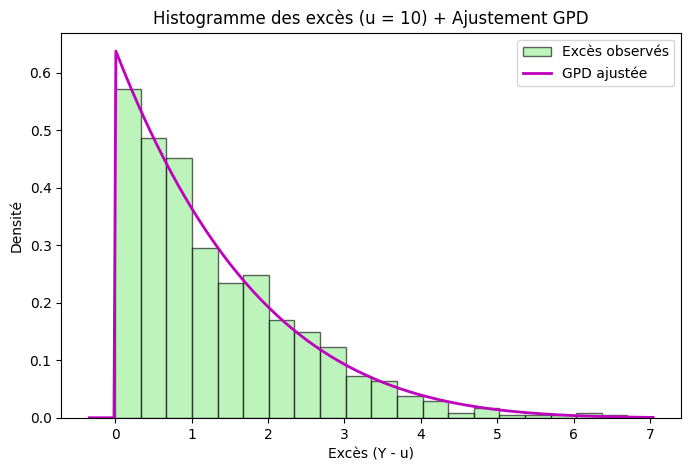

In [113]:
# Histogramme des excès avec la densité GPD ajustée
plt.figure(figsize=(8,5))

# Histogramme normalisé
plt.hist(exces, bins=20, density=True, alpha=0.6,
         color="lightgreen", edgecolor="black", label="Excès observés")

# Domaine pour la courbe
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 300)

# Courbe GPD ajustée
plt.plot(xx, genpareto.pdf(xx, *params_gpd), 'm-', lw=2,
         label="GPD ajustée")

plt.xlabel("Excès (Y - u)")
plt.ylabel("Densité")
plt.title(f"Histogramme des excès (u = {u}) + Ajustement GPD")
plt.legend()
plt.show()

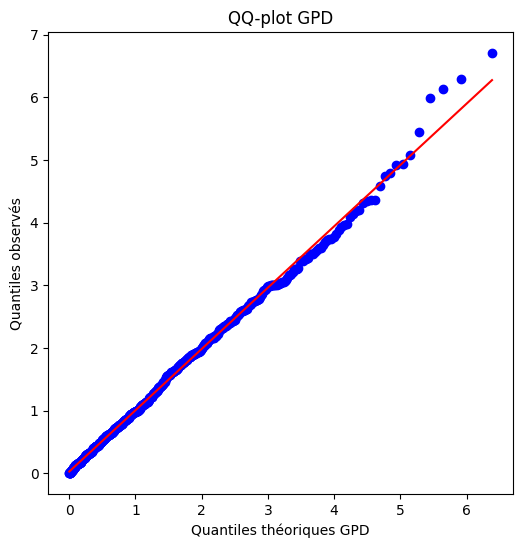

In [114]:
# QQ-plot pour vérifier si les excès suivent bien une GPD
plt.figure(figsize=(6,6))
st.probplot(exces, dist=genpareto(*params_gpd), plot=plt)

plt.title("QQ-plot GPD")
plt.xlabel("Quantiles théoriques GPD")
plt.ylabel("Quantiles observés")
plt.show()

In [115]:
# Test KS pour la GPD ajustée
ks_gpd = kstest(exces, 'genpareto', params_gpd)
print("KS-test GPD :", ks_gpd)
print("p-value :", ks_gpd.pvalue)

KS-test GPD : KstestResult(statistic=np.float64(0.02281440715189699), pvalue=np.float64(0.8510942672811159), statistic_location=np.float32(0.13415241), statistic_sign=np.int8(-1))
p-value : 0.8510942672811159
